<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/PINN_para_modelo_de_crescimento_exponencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Esse notebook é destinado a gerar um código teste para a PINN.

Como visto, informar a condição de contorno e aplicar as EDPs melhora o aprendizado da rede, mas como?

Tendo como maior exemplo a rede neural trabalhada até agora para simular o caso de Su, o que poderia acontecer ao informarmos os dados é o seguinte:

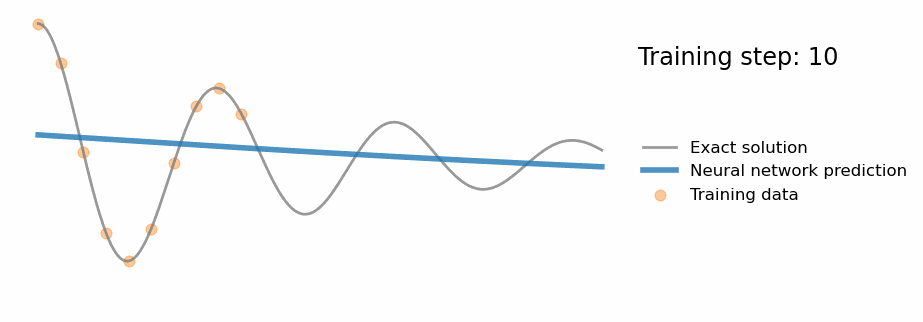

Em que um determinado ponto a rede não consegue aproximar bem os pontos além do alcance dos dados informados, mesmo variando o número de épocas, ou seja: embora a rede neural modele com precisão o processo físico nas proximidades dos dados experimentais, ela não consegue generalizar esses dados de treinamento, sendo essa a principal desvantagem das RNAs

Encarando o gráfico como um sistema massa-mola amortecido, a equação diferencial que rege o sistema é:

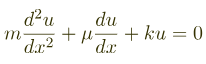

Com m sendo a massa do bloco, mi o coeficiente de atrito e k a constante da mola, a função de custo (nesse site que eu encontrei) fica definida como:

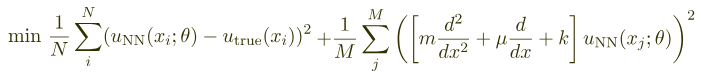

Com isso, o gráfico da rede neural com o histórico de treinamentos é exibido pelo gif:

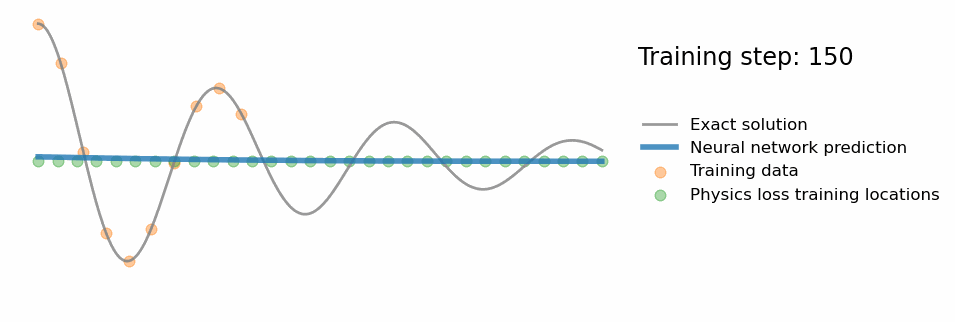

#Criando a rede neural

Usando o pytorch

In [1]:
#Realizando imports
import torch
import torch.nn as nn
from torch.func import functional_call, grad, vmap
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import  MeanRelativeError

<ipython-input-2-e72021a5b9fa>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')


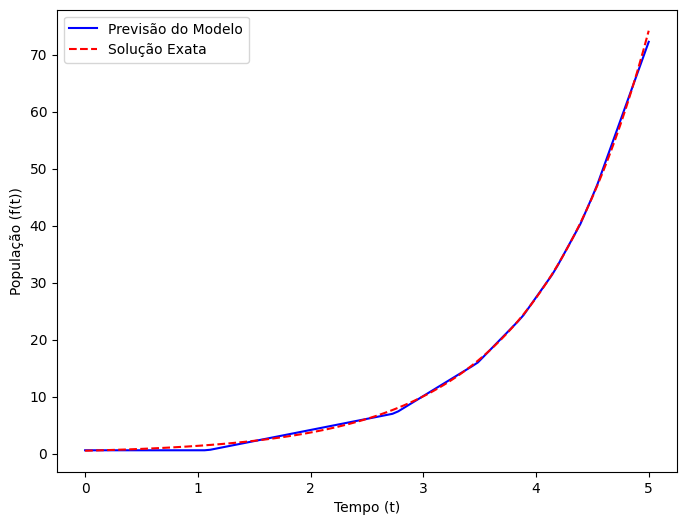

In [2]:
#Crie dados de treinamento
t = np.linspace(0, 5, 100).reshape(-1, 1).astype(np.float32)
y_real = 0.5 * np.exp(t).astype(np.float32)  #Usando essa equação porque acho que ela consegue resolver a condição de contorno

#Número de camadas ocultas
num_ocultas = 3

#Modelo Multi camadas que nem o tensorflow
modelo = nn.Sequential(
    nn.Linear(1, 10),  # Camada de entrada
    nn.ReLU(),  # Função de ativação ReLU
)

for i in range(num_ocultas):
    modelo.add_module('linear', nn.Linear(10, 10))  # Camada oculta
    modelo.add_module('relu', nn.ReLU())  # Função de ativação ReLU

modelo.add_module('output', nn.Linear(10, 1))  # Camada de saída

#Calculo da função custo (erro médio quadrático)
custo = nn.MSELoss()

#otimizador (Adam)
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.01)

#modelo
for itr in range(1000):
    otimizador.zero_grad()
    f_pred = modelo(torch.tensor(t))
    loss = custo(f_pred, torch.tensor(y_real))
    loss.backward()
    otimizador.step()


t_pred = np.linspace(0, 5, 100).reshape(-1, 1).astype(np.float32)
y_pred = modelo(torch.tensor(t_pred)).detach().numpy()


plt.figure(figsize=(8, 6))
plt.plot(t_pred, y_pred, label='Previsão do Modelo', color='blue')
plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')
plt.xlabel('Tempo (t)')
plt.ylabel('População (f(t))')
plt.legend()
plt.show()


4/4 [==============================] - 0s 4ms/step


<ipython-input-5-7065b83c3497>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')


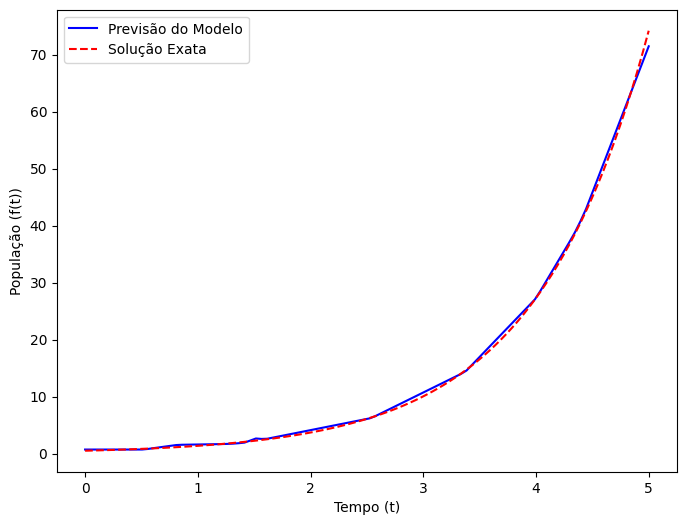

In [5]:
t = np.linspace(0, 5, 100).reshape(-1, 1).astype(np.float32)
y_real = 0.5 * np.exp(t).astype(np.float32)

modelo = tf.keras.Sequential()
modelo.add(tf.keras.layers.Dense(10, activation='relu', input_shape = (1,)))
for _ in range(3):
    modelo.add(tf.keras.layers.Dense(10, activation='relu'))

#Camada de saída
modelo.add(tf.keras.layers.Dense(1, activation='linear'))

modelo.compile(optimizer='adam', loss='mean_squared_error')

#Treino do modelo
history = modelo.fit(t, y_real, epochs=1000, verbose=0)

t_pred = np.linspace(0, 5, 100).reshape(-1, 1).astype(np.float32)
y_pred = modelo.predict(t_pred)

#Plot
plt.figure(figsize=(8, 6))
plt.plot(t_pred, y_pred, label='Previsão do Modelo', color='blue')
plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')
plt.xlabel('Tempo (t)')
plt.ylabel('População (f(t))')
plt.legend()
plt.show()

<ipython-input-4-260adf4f4b5d>:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')


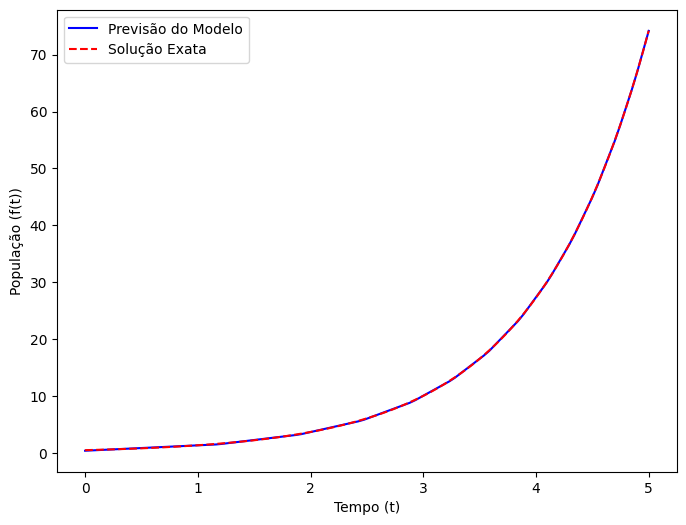

In [4]:
#Geração de dados de treinamento
t = np.linspace(0, 5, 100).reshape(-1, 1).astype(np.float32)
y_real = 0.5 * np.exp(t).astype(np.float32)  #Equação exata do exemplo do site

#Número de camadas ocultas
num_ocultas = 3

#Modelo Multi camadas que nem o tensorflow
modelo = nn.Sequential(
    nn.Linear(1, 10),  # Camada de entrada
    nn.ReLU(),  # Função de ativação ReLU
)

for i in range(num_ocultas):
    modelo.add_module('linear', nn.Linear(10, 10))  # Camada oculta
    modelo.add_module('relu', nn.ReLU())  # Função de ativação ReLU

modelo.add_module('output', nn.Linear(10, 1))  # Camada de saída

#função de perda para a EDP
def loss_EDP(y_pred, t):
    f_t = 0.5 * torch.exp(t)
    pred_t = torch.autograd.grad(outputs=y_pred, inputs=t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    loss_EDP = torch.mean((pred_t - f_t)**2)
    return loss_EDP

#Calculo da função custo (erro médio quadrático)
custo = nn.MSELoss()

#aplicando o otimizador (adam, pois era o usado na RNA com tensorflow)
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.01)

#Treino do modelo
for epoch in range(10000):
    otimizador.zero_grad()
    t_batch = torch.tensor(t, requires_grad=True)
    y_pred = modelo(t_batch)
    loss_EDP_value = loss_EDP(y_pred, t_batch)
    loss_bc_value = custo(y_pred, torch.tensor(y_real))
    loss = loss_EDP_value + loss_bc_value
    loss.backward()
    otimizador.step()

#previsões com o modelo treinado
t_pred = torch.tensor(t)
y_pred = modelo(t_pred).detach().numpy()

#resultados
plt.figure(figsize=(8, 6))
plt.plot(t_pred, y_pred, label='Previsão do Modelo', color='blue')
plt.plot(t, y_real, 'r--', label='Solução Exata', color='red')
plt.xlabel('Tempo (t)')
plt.ylabel('População (f(t))')
plt.legend()
plt.show()